# Predict the Outcome of Bank Telemarketing Using Machine Learning Approaches on Cloud 

<h3><center>Thejas Prasad</center></h3>

<h3><center>Machine Learning in Google Cloud Platform</center></h3>

 <h3><center>04/11/2018</center></h3>

## Data Set Information:
The data are related to direct marketing campaigns of a Portuguese banking institution. Data were obtained from the UCI Machine Learning Repository. Marketing campaigns were based on phone calls; often, more than one contact to the same client was required in order to assess if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

We will use the full dataset for this analysis, which contains 41188 observations and 20 inputs, ordered by date (from May 2008 to November 2010). The dataset is publicly available here: https://archive.ics.uci.edu/ml/datasets/bank+marketing

## Attribute Information:
### Input variables:
#### bank client data:
  - age (numeric)
  - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown') 
  - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed) 
  - education(categorical:'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown') 
  - default: has credit in default? (categorical: 'no','yes','unknown') 
  - housing: has housing loan? (categorical: 'no','yes','unknown') 
  - loan: has personal loan? (categorical: 'no','yes','unknown')
#### related with the last contact of the current campaign:
  - contact: contact communication type (categorical: 'cellular','telephone')  
  - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec') 
  - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri') 
  - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
#### other attributes:
  - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact) 
  - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted) 
  - previous: number of contacts performed before this campaign and for this client (numeric) 
  - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
#### social and economic context attributes
  - emp.var.rate: employment variation rate - quarterly indicator (numeric) 
  - cons.price.idx: consumer price index - monthly indicator (numeric)  
  - cons.conf.idx: consumer confidence index - monthly indicator (numeric)  
  - euribor3m: euribor 3 month rate - daily indicator (numeric) 
  - nr.employed: number of employees - quarterly indicator (numeric)
### Output variable (desired target):
  - y - has the client subscribed a term deposit? (binary: 'yes','no')

### Import date from GCP storage

In [1]:
from google.datalab import Context
#import google.datalab.bigquery as bq
import google.datalab.storage as storage
import pandas as pd
try:
  from StringIO import StringIO
except ImportError:
  from io import BytesIO as StringIO

ModuleNotFoundError: No module named 'google.datalab'

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# access bank data stored in the bucket
%%gcs read --object gs://termp/bankData.csv --variable bank

SyntaxError: invalid syntax (<ipython-input-2-503f526ba603>, line 2)

In [5]:
# read varible bank as a data frame
bank = pd.read_csv(StringIO(bank))
bank.shape

(41188, 21)

In [18]:
# an alternative way to import bank data from stroage as a data frame
bank2 = storage.Object('termp', 'bankData.csv').read_stream()
bank2 = pd.read_csv(StringIO(bank2))
bank2.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
# check missing value
bank.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [7]:
# separate the dataset into X, y
Xb, yb = bank.iloc[:, :-1], bank.iloc[:, -1]
Xb.shape

(41188, 20)

### Feature engineering

In [8]:
# y is very unbalanced, with small sample proportions of y distorting predictive abilities of analysis. 
bank.groupby('y').size()

y
no     36548
yes     4640
dtype: int64

In [9]:
# one hot encoding for y
y_encode = pd.get_dummies(yb, prefix='deposit', drop_first= True)

# set deposit = 'yes' as target
y_encode.head(3)

,deposit_yes
0,0
1,0
2,0


In [10]:
# Return a contiguous flattened array 
y = np.ravel(y_encode)

In [11]:
# Remove 'duration' variable, which was found to be highly collinear with output variable ('yes').
# Longer phone calls were strongly correlated with outcome.
del Xb['duration']

In [12]:
# one-hot encoding for X
X_encode = pd.get_dummies(Xb)
X_encode.shape

(41188, 62)

In [13]:
# standardize features for further analysis
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()
X = scl.fit_transform(X_encode)

#### Dataset description
- No missing values were reported
- Removed 'duration' as indicated previously. 
- Most features were categorical, so one-hot encoding was applied. Total of 62 features are in the final dataset after one-hot encoding.

#### Choose proper evaluation metrics for the classifiers
- F1 score was used as the evaluation metric: since the desired target had unbalanced proportions (36.5K 'No' vs 4.6K 'Yes') and No >> Yes, F1 was a proper metric to use. Accuracy is not suitable because classifiers are biased towards larger proportion classes. For example, the average accuracy for this dataset could reach 91% (very high accuracy on "No," but very low on "yes"), but the best F1 score obtained was around 56%.  
- The F1 score for classification was obtained via cross_val_score combining Stratified ShuffleSplit cross-validator. The samples were randomized, stratified and cross-validated during classfication, which makes F1 a reliable metric for comparison.

### RandomForest classifier

In [14]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.model_selection import cross_val_score

# create cross validation iterator
cv = StratifiedShuffleSplit( n_splits=10, test_size=0.2)

# tune the significant parameter n_estimators
estimator_list = [100, 200, 300]
for n in estimator_list:
    clf_rf = RandomForestClassifier(n_estimators=n, random_state=1)
    scores_rf = cross_val_score(clf_rf, X, y=y, cv=cv, scoring = 'f1', n_jobs=-1) 
# The mean accuracy score and the 95% confidence interval of the score estimate 
    print(n,":CI of RandomForest f1 is %0.3f +/- %0.3f" % (scores_rf.mean(), scores_rf.std()*2))

100 :CI of RandomForest f1 is 0.377 +/- 0.030
200 :CI of RandomForest f1 is 0.378 +/- 0.031
300 :CI of RandomForest f1 is 0.384 +/- 0.027
CPU times: user 5min 9s, sys: 1.57 s, total: 5min 11s
Wall time: 5min 13s


### K-neighbors classifier

In [16]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.model_selection import cross_val_score

# create cross validation iterator
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2)

# tune the significant parameter n_neighbors
for n in range(5, 12, 2):
    clf_knn = KNeighborsClassifier(n_neighbors=n)
    scores_knn = cross_val_score(clf_knn, X, y=y, cv=cv, scoring = 'f1', n_jobs=-1) 
    # The mean score and the 95% confidence interval of the score estimate 
    print(n,":CI of KNN f1 is %0.3f +/- %0.3f" % (scores_knn.mean(), scores_knn.std()*2))

5 :CI of KNN f1 is 0.351 +/- 0.021
7 :CI of KNN f1 is 0.345 +/- 0.018
9 :CI of KNN f1 is 0.344 +/- 0.029
11 :CI of KNN f1 is 0.352 +/- 0.024
CPU times: user 29min 11s, sys: 591 ms, total: 29min 12s
Wall time: 29min 21s


### SVM classifier with stochastic gradient descent

In [17]:
%%time
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.model_selection import cross_val_score

# create cross validation iterator
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2)

# optimize the significant parameter alpha.
a_list= [0.0001, 0.001, 0.01]
for a in a_list:
    svm_sgd = SGDClassifier(alpha=a, fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter=200, n_jobs=-1, penalty='l2')
    scores_sgd = cross_val_score(svm_sgd, X, y=y, cv=cv, scoring = 'f1', n_jobs=-1) 

    # The mean score and the 95% confidence interval of the score estimate 
    print(a, ":CI of SVM_sgd f1 is %0.3f +/- %0.3f" % (scores_sgd.mean(), scores_sgd.std()*2))

0.0001 :CI of SVM_sgd f1 is 0.307 +/- 0.042
0.001 :CI of SVM_sgd f1 is 0.298 +/- 0.028
0.01 :CI of SVM_sgd f1 is 0.310 +/- 0.044
CPU times: user 1min 20s, sys: 78 ms, total: 1min 20s
Wall time: 1min 21s


### Compare accuracy for three classfiers

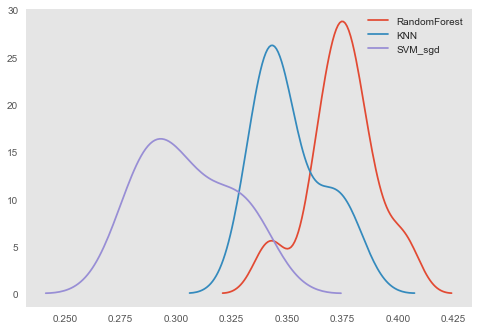

In [37]:
# plot accuracy scores for the three classifiers, choose the best parameters for each classifier.
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

# obtain f1 scores for all classifers.
clf_rf = RandomForestClassifier(n_estimators=200, random_state=1)
scores_rf = cross_val_score(clf_rf, X, y=y, cv=cv, scoring= 'f1', n_jobs=-1) 

clf_knn = KNeighborsClassifier(n_neighbors=9)
scores_knn = cross_val_score(clf_knn, X, y=y, cv=cv, scoring= 'f1', n_jobs=-1) 

svm_sgd = SGDClassifier(alpha=0.001, fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter=200, n_jobs=-1, penalty='l2')
scores_sgd = cross_val_score(svm_sgd, X, y=y, cv=cv, scoring= 'f1', n_jobs=-1) 

# kde plots
sns.kdeplot(scores_rf, label="RandomForest")
sns.kdeplot(scores_knn, label="KNN")
sns.kdeplot(scores_sgd, label="SVM_sgd")
plt.grid()
plt.legend()

Using kernel density estimation to plot the accuracy of each classifier shows the probability density of the F1 score and the width of the spread.

#### Summary of the three classifiers for task1
- RandomForest has the best f1 score with 95% CI estimate: RandomForest(0.384 +/- 0.027), KNN(0.352 +/- 0.024) and SVM_sgd (0.310 +/- 0.044. SVM_sgd has lowest f1. The difference is up to 8%.
- In terms of running time, SVM-sgd handles large dataset well (>41k instances). It runs significantly faster than KNN. KNN is the slowest here. RandomForest runs fairly quickly, though slower than SVM-sgd.
- Taking three candidate classication methods into consideration, we recommend using the RandomForest classfier to determine which marketing campaigns were most effective in increasing term deposit subscriptions.   

### Assess feature importance using RandomForest

In [15]:
# investigate feature importance for RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=200, random_state=1)

clf_rf.fit(X, y)
importances = clf_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feat_label = X_encode.columns

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f+1, feat_label[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature age (0.163990)
2. feature euribor3m (0.120277)
3. feature campaign (0.084107)
4. feature nr.employed (0.046584)
5. feature pdays (0.032278)
6. feature cons.conf.idx (0.027427)
7. feature poutcome_success (0.025497)
8. feature cons.price.idx (0.021095)
9. feature housing_no (0.021063)
10. feature housing_yes (0.020781)
11. feature emp.var.rate (0.019875)
12. feature job_admin. (0.017473)
13. feature marital_married (0.016349)
14. feature education_university.degree (0.016302)
15. feature education_high.school (0.016229)
16. feature marital_single (0.014790)
17. feature day_of_week_mon (0.014516)
18. feature day_of_week_wed (0.014328)
19. feature day_of_week_thu (0.014215)
20. feature day_of_week_tue (0.014092)
21. feature job_technician (0.014064)
22. feature previous (0.013892)
23. feature loan_no (0.013873)
24. feature loan_yes (0.013636)
25. feature day_of_week_fri (0.013544)
26. feature education_professional.course (0.011938)
27. feature job_blue-collar 

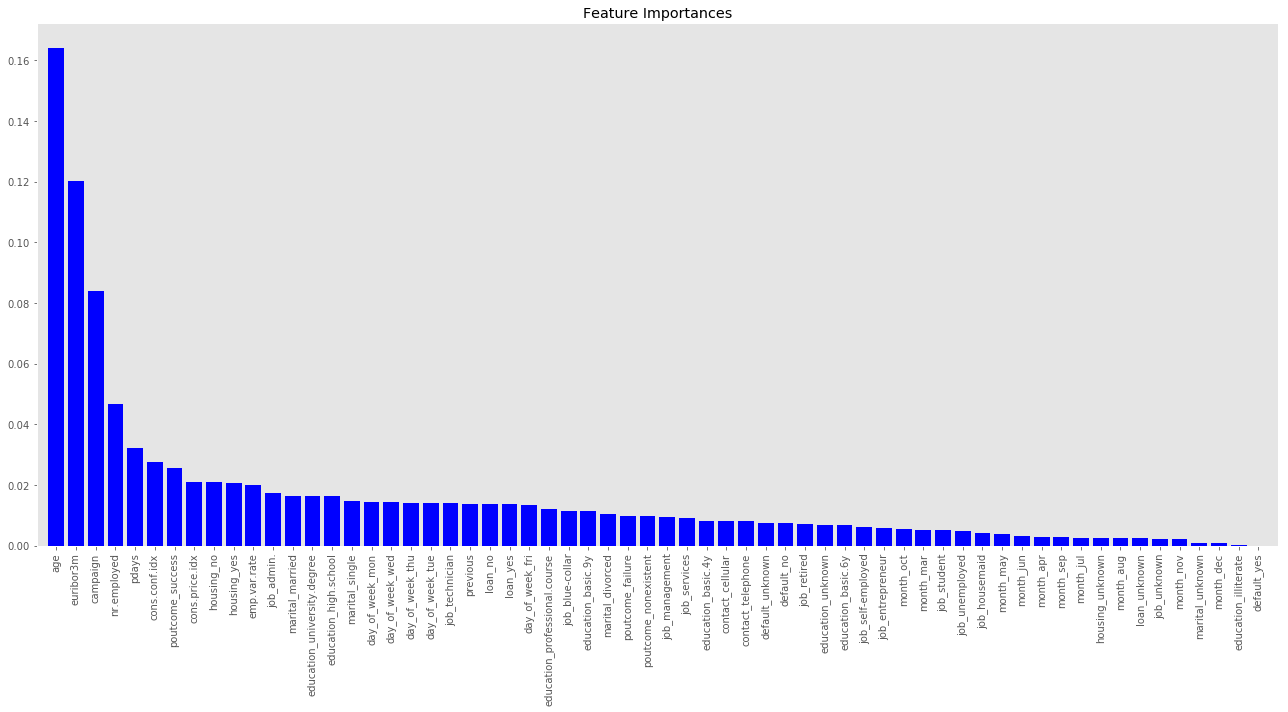

In [23]:
# plot the rank of features

plt.figure(figsize=(18,10))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]),importances[indices],color='blue',align='center')
plt.xticks(range(X.shape[1]),feat_label[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.grid()
plt.show()

#### Important features for randomforest classifier
- The three most important features are age, euribor 3 month rate, and number of contacts performed during this campaign for this client. Age has a significant impact on this classification. Certain age group(s) might be more important than others. We advice marketing campaigns to take this into consideration.
- The choice of the most important features here is arbitary. Besides the three most important ones, the fourth one "number of employees"  also contributes to the classification.

## Additional model using clustering to discretize features

The 20 features in this dataset are grouped into several loose categories as shown in data description. We used clustering to discretize several features in one category. For example, clustering attributes in group called "other attritutes" and convert them into discrete features.  

In [64]:
# data with attrs from group "other attributes"
X6 = Xb[['campaign','pdays','previous']]
# one-hot encoding the catergorical feature 'poutcome' and add it back to X7
Xp = np.column_stack((X6, pd.get_dummies(Xb['poutcome'])))

In [65]:
Xo = Xb
del Xo['campaign']
del Xo['pdays']
del Xo['previous']
del Xo['poutcome']

# data without attributes from group named other attributes 
X7 = Xo

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans

# clustering Xp using KMeans
cls = KMeans(n_clusters=8, init='k-means++',random_state=1)
cls.fit(Xp)
newfeature2 = cls.labels_ # obtain new features after clustering

cv = StratifiedShuffleSplit( n_splits=10, test_size=0.2)
clf = RandomForestClassifier(n_estimators=200, random_state=1)

# add new features after clustering back to X7
X8 = np.column_stack((pd.get_dummies(newfeature2), pd.get_dummies(X7)))
scores_km = cross_val_score(clf, X8, y=y, scoring = 'f1', cv=cv)

print("CI of RandomForest f1 (with kmeans for other attrs) is %0.3f +/- %0.3f" % (scores_km.mean(), scores_km.std()*2))

CI of RandomForest f1 (with kmeans for other attrs) is 0.556 +/- 0.031


#### Compared to the F1 score in RandomForest classifier without clustering (0.377), the new model with discretizated features increased F1 score to 0.556, a gain of around 18%.

### Deployment
- Among all classifiers tested, the RandomForest classifier performed best. Combining RandomForest with clustering to convert original features into discrete features could improve model accuracy. Thus we would recommend this classifier to interested parties. 
- Strategies to improve the performance of the models: 
  - correct unbalanced classes in the desired target. For example, 'NO' is 10 times more than 'YES' in the classification targt of task1. Classifiers tend to be biased toward the class with the larger proportions. In preprocessing, many actions can be taken to control for the impact of small samples proportions; e.g., if possible, increase sample size of the class with small proportion to correct the asymmetry in proportions. 
  - update model with sensitive features frequently. Based on the results of this analysis, social and economic attributes seem important in predicting model outcomes. Models should therefore be updated frequently to reflect changes in economic conditions. As suggested by the dataset, the chosen model needs to be updated around every 3 months.
  - use proper metric to measure the model's values. The metric would be chosen based on the nature of the datasets and the classification targets of the datasets from interested parties. In general, Accuracy is good for the datasets with balanced classes. F1 is more suitable for datasets with unbalanced classes such as the dataset we used here.   

### Reference
Moro, S., Cortez, P., & Rita, P. (2014). A data-driven approach to predict the success of bank telemarketing. Decision Support Systems, 62, 22-31.

### Code Reference
Python machine learning by S.Raschka